In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV, gp_minimize, load
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, roc_curve

# Load data

In [6]:
%%time
train = pd.read_csv("data/train.csv")
print(train.shape)

(200000, 202)
CPU times: user 6.34 s, sys: 524 ms, total: 6.86 s
Wall time: 6.93 s


In [7]:
%%time
test = pd.read_csv("data/test.csv")
print(test.shape)

(200000, 201)
CPU times: user 5.86 s, sys: 469 ms, total: 6.33 s
Wall time: 6.43 s


In [8]:
def fit_model(stratified, n_folds):
    
    if stratified:
        folds = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 0)
    else:
        folds = KFold(n_splits = n_folds, shuffle = True, random_state = 0)
    
    features = [f for f in train.columns if f not in ['target', 'ID_code']]
    
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    
    scores = []
    
    feature_importance_df = pd.DataFrame()
    
    params = {'n_iter': 1000,
              'learning_rate': 0.1,
              'max_depth': -1,
              'num_leaves': 13,
              'colsample_bytree': 0.05,
              'subsample': 1,
              'lambda_l1': 0,
              'lambda_l2': 0,
              'min_data_in_leaf': 80,
              'min_sum_hessian': 10}
    
    for n_fold, (train_index, valid_index) in enumerate(folds.split(train[features], train['target'])):
        print(f"Fold: {n_fold + 1}, test index: {valid_index[0]}-{valid_index[-1]}")
        X_train, y_train = train[features].iloc[train_index], train['target'].iloc[train_index]
        X_valid, y_valid = train[features].iloc[valid_index], train['target'].iloc[valid_index]
    
        clf = LGBMClassifier(objective = 'binary',
                             metric = 'auc',
                             random_state = 0,
                             n_thread = 4,
                             scale_pos_weight = 0.9,
                             **params)
        
        clf.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=100, 
              early_stopping_rounds=100)
        
        oof_preds[valid_index] = clf.predict_proba(X_valid, n_iter=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        score = roc_auc_score(y_valid, oof_preds[valid_index])
        scores.append(score)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print(f"AUC fold {n_fold + 1}: {score}")
    
    cv = np.mean(scores)
    print(f"Fold scores: {scores}\nAverage score(CV): {cv}")
    
    importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False).reset_index()
    
    sub_df = pd.DataFrame({'ID_code': test.ID_code.values, 'target': sub_preds})
    sub_df.to_csv('submission' + dt.datetime.now().strftime("%Y%m%d_%H%M%S"), index= False)
        
    return cv, importance_df

In [9]:
cv, importance_df = fit_model(True, 5)

Fold: 1, test index: 5-199996


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.861472
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.861472
AUC fold 1: 0.8614722308526294
Fold: 2, test index: 0-199999


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.862755
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862755
AUC fold 2: 0.8627551080372573
Fold: 3, test index: 3-199998


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.866425
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.866425
AUC fold 3: 0.8664247412188639
Fold: 4, test index: 1-199991


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.873041
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.873041
AUC fold 4: 0.8730411244199835
Fold: 5, test index: 2-199987


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.867755
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.867755
AUC fold 5: 0.8677546592540353
Fold scores: [0.8614722308526294, 0.8627551080372573, 0.8664247412188639, 0.8730411244199835, 0.8677546592540353]
Average score(CV): 0.8662895727565539


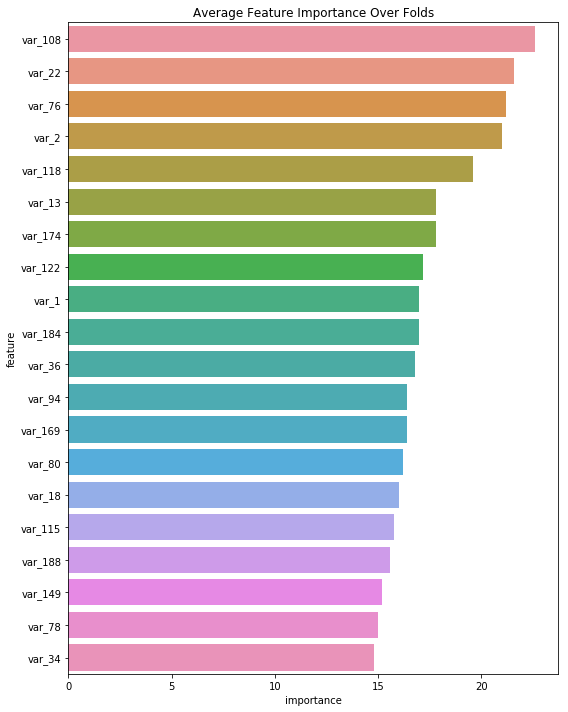

In [15]:
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", data=importance_df.sort_values(by="importance", ascending=False).iloc[0:20])
plt.title('Average Feature Importance Over Folds')
plt.tight_layout()

In [ ]:
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

In [ ]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = LGBMClassifier(objective = 'binary',
                               metric = 'auc',
                               random_state = 0,
                               n_thread = 4,
                               verbose = 3,
                               learning_rate = 0.05),
    search_spaces = {
        'n_estimators': (10, 20),
        'num_leaves': (1, 100),      
        'max_depth': (0, 10),
        'max_bin': (100, 1000),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 10),
        'reg_lambda': (0, 10),
        'reg_alpha': (0, 10),
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=0
    ),
    n_jobs = 3,
    n_iter = 3,   
    verbose = 3,
    refit = True,
    random_state = 0
)

def status_print(optim_result):
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    
    print(f"Model #{len(all_models)}\
    \nBest Score: {np.round(bayes_cv_tuner.best_score_, 4)}\
    \nBest params: {bayes_cv_tuner.best_params_}")
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

features = [f for f in train.columns if f not in ['target', 'ID_code']]

# Fit the model
result = bayes_cv_tuner.fit(train[features], train['target'], callback=status_print)

In [55]:
def obj_fun(x):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * 0.1

checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9) # keyword arguments will be passed to `skopt.dump`

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0054
Function value obtained: 0.0391
Current minimum: -0.2625
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0050
Function value obtained: -0.0762
Current minimum: -0.2625
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.1899
Function value obtained: 0.0528
Current minimum: -0.2625
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.1936
Function value obtained: 0.0428
Current minimum: -0.2625
Iteration No: 5 started. Searching for the next optimal point.


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 0.2040
Function value obtained: 0.1660
Current minimum: -0.2625
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 0.4054
Function value obtained: -0.0316
Current minimum: -0.2625


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


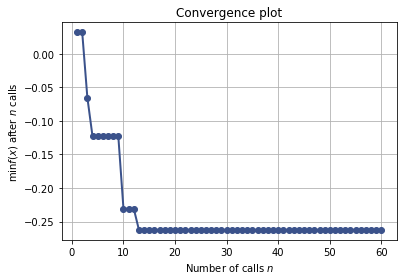

In [178]:
try:
    res = load('./checkpoint.pkl')

    x_init = res.x_iters
    y_init = res.func_vals
    exploration_iters = 2
    n_iters = 5
except:
    x_init = None
    y_init = None
    exploration_iters = 1
    n_iters = 5
    n_iters = max(n_iters, exploration_iters)
finally:
    res = gp_minimize(obj_fun,            # the function to minimize
              [(-20.0, 20.0)],    # the bounds on each dimension of x
              x0=x_init,              # already examined values for x
              y0=y_init,              # observed values for x0
              acq_func="LCB",     # the acquisition function (optional)
              n_calls=n_iters,         # the number of evaluations of f including at x0
              n_random_starts=exploration_iters,  # the number of random initialization points
              callback=[checkpoint_saver],
              random_state=777, 
              verbose = True)
    plot_convergence(res)

In [181]:
os.remove('checkpoint.pkl')